## I. Introduction

### 1. Purpose

This validation task is designed to confirm that gis environmental-factor extraction logic (implemented in the Jupyter notebook extract_environmental_factor_each_farm.ipynb) produces results consistent with the Product Owner (PO) dataset. In short, I use the PO environmental dataset as a reference to build environmental factors for all farms in gis dataset and then compare gis outputs against the corresponding PO farm environmental factors.

The validation workflow includes four main steps:

1. Spatial matching (latitude/longitude): each farm is paired with its nearest PO farm using coordinate proximity.

2. Field-by-field agreement: numeric variables are compared using predefined tolerance thresholds, while categorical variables require exact matches.

3. Score-based matching: farms can still be considered “mostly matched” when the majority of fields agree (e.g., 5 out of 6 fields match).

4. Overall consistency checks: Pearson and Spearman correlations are calculated to assess how strongly gis farm and PO values align across farms and variables.

### 2. Datasets and Expected Columns

##### 2.1 Data Location
- `all_farm_environmental_factors.csv` (File is stored in **Githb → gis → notebook → GIS**. ) [GIS Dataset]

- `farm_boundaries_sampled.gpkg` (File is stored in **MS Teams → Files → Datasets → GIS**. ) [PO Dataset]

##### 2.2 Dataset variable

*Required*
- `lat`,`lon` 

*Validated files*
- `temperature_celsius` : *(int)*
- `rainfall_mm` : *(int)*
- `elevation_m` : *(int)*
- `ph`:  *(float)*
- `area_ha`: *(float)*
- `soil_texture_list`: *(string)*


## II. Implementation

- Import necessary library


In [47]:
import pandas as pd
import geopandas as gpd
import os
import re
import numpy as np
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt

- Import file dataset


In [48]:
# Get the current working directory
base_dir = os.getcwd()

# Build the path
gpkg_path = os.path.join(base_dir, "../assets/farm_boundaries_sampled.gpkg")

# Read farm dataset
po_farms = gpd.read_file(gpkg_path)

# Drop farmer name
po_farms.drop(columns=["name"], inplace=True)

# Print first few row
po_farms.head()

,treeo2_id,district,subdistrict,suku,aldeia,texture,ph,avg_annual_rainfall_2020-2024,avg_annual_temperature_2020-2024,elevation,area,area_ha,geometry
0,,BAUCAU,BAGUIA,Lavateri,Onortibalari,Clay,6.2,1959,24.0,585,3596.997671,0.36,"MULTIPOLYGON Z (((904783.597 9050919.352 0, 90..."
1,,BAUCAU,BAGUIA,Lavateri,Onortibalari,Clay,6.2,1959,24.0,481,4815.008969,0.48,"MULTIPOLYGON Z (((905235.474 9051056.651 0, 90..."
2,,VIQUEQUE,UATUCARBAU,Alaua-Craik,Neolidae,Sandy Loam,8.2,2021,25.0,179,11844.528814,1.18,"MULTIPOLYGON Z (((903414.205 9042747.721 0, 90..."
3,,VIQUEQUE,UATUCARBAU,Alaua-Craik,Neolidae,Sandy Loam,5.9,2554,24.0,260,4567.518936,0.46,"MULTIPOLYGON Z (((902007.836 9043097.668 0, 90..."
4,,BAUCAU,BAGUIA,Alaua-Craik,Neolidae,Clay,7.0,2021,25.0,129,19952.902237,2.00,"MULTIPOLYGON Z (((904016.568 9042595.439 0, 90..."


In [49]:
# Check data information
po_farms.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   treeo2_id                         2267 non-null   object  
 1   district                          3201 non-null   object  
 2   subdistrict                       3201 non-null   object  
 3   suku                              3201 non-null   object  
 4   aldeia                            1902 non-null   object  
 5   texture                           3154 non-null   object  
 6   ph                                3154 non-null   object  
 7   avg_annual_rainfall_2020-2024     3201 non-null   int32   
 8   avg_annual_temperature_2020-2024  3193 non-null   float64 
 9   elevation                         3201 non-null   int32   
 10  area                              3201 non-null   float64 
 11  area_ha                           3201 non-null 

In [50]:
# Build the path
gis_farms_path = os.path.join(
    base_dir, "../notebook/all_farm_environmental_factors.csv"
)

# Read distance of farm to costal, which is calculating by using QGIS
gis_farms = pd.read_csv(gis_farms_path)

# Print first few row
gis_farms.head()

,farm_id,lon,lat,area_ha,temperature_celsius,rainfall_mm,soil_texture_list,elevation_m,slope,dist_to_coast_km,coastal,ph,soil_texture_id
0,1,126.675704,-8.568798,0.369033,24.0,1959,clay,585,13.114323,13.679863,False,6.2,12.0
1,2,126.680149,-8.567578,0.493987,24.0,1959,clay,481,13.937272,13.708429,False,6.2,12.0
2,3,126.664651,-8.642259,1.215683,25.0,2021,sandy loam,178,11.151526,13.387161,False,8.2,3.0
3,4,126.651458,-8.639690,0.468802,24.0,2554,sandy loam,260,15.552424,13.966934,False,5.9,3.0
4,5,126.670084,-8.643001,2.047884,25.0,2021,clay,131,7.615144,13.223976,False,7.0,12.0


In [51]:
# Check data information
gis_farms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   farm_id              3195 non-null   int64  
 1   lon                  3195 non-null   float64
 2   lat                  3195 non-null   float64
 3   area_ha              3195 non-null   float64
 4   temperature_celsius  3186 non-null   float64
 5   rainfall_mm          3195 non-null   int64  
 6   soil_texture_list    3148 non-null   object 
 7   elevation_m          3195 non-null   int64  
 8   slope                3195 non-null   float64
 9   dist_to_coast_km     3195 non-null   float64
 10  coastal              3195 non-null   bool   
 11  ph                   3148 non-null   float64
 12  soil_texture_id      3097 non-null   float64
dtypes: bool(1), float64(8), int64(3), object(1)
memory usage: 302.8+ KB


##### Validation the environmental factors in each farm between PO dataset and GIS dataset

1. Transform PO dataset into necessary variable for validation 

- Add Uniques Farm ID for PO dataset

In [52]:
# Reset index to create a unique Farm ID column
po_farms = po_farms.reset_index(drop=True)
po_farms["farm_id"] = range(1, len(po_farms) + 1)
cols = ["farm_id"] + [c for c in po_farms.columns if c != "farm_id"]
po_farms = po_farms[cols]

- Add Latitude and Longitude to Each Farm for PO dataset

In [53]:
# Calculate the centroid of each farm's geometry
po_farms["centroid_geometry"] = po_farms.geometry.centroid

# Reproject the centroid geometries to EPSG:4326 to get latitude and longitude
centroids_latlon = po_farms["centroid_geometry"].to_crs(epsg=4326)

# Extract latitude and longitude
po_farms["longitude"] = centroids_latlon.x
po_farms["latitude"] = centroids_latlon.y


# Print first few row
po_farms.head(5)

,farm_id,treeo2_id,district,subdistrict,suku,aldeia,texture,ph,avg_annual_rainfall_2020-2024,avg_annual_temperature_2020-2024,elevation,area,area_ha,geometry,centroid_geometry,longitude,latitude
0,1,,BAUCAU,BAGUIA,Lavateri,Onortibalari,Clay,6.2,1959,24.0,585,3596.997671,0.36,"MULTIPOLYGON Z (((904783.597 9050919.352 0, 90...",POINT (904745.475 9050883.409),126.675704,-8.568798
1,2,,BAUCAU,BAGUIA,Lavateri,Onortibalari,Clay,6.2,1959,24.0,481,4815.008969,0.48,"MULTIPOLYGON Z (((905235.474 9051056.651 0, 90...",POINT (905236.909 9051013.85),126.680149,-8.567578
2,3,,VIQUEQUE,UATUCARBAU,Alaua-Craik,Neolidae,Sandy Loam,8.2,2021,25.0,179,11844.528814,1.18,"MULTIPOLYGON Z (((903414.205 9042747.721 0, 90...",POINT (903448.814 9042757.544),126.664651,-8.642259
3,4,,VIQUEQUE,UATUCARBAU,Alaua-Craik,Neolidae,Sandy Loam,5.9,2554,24.0,260,4567.518936,0.46,"MULTIPOLYGON Z (((902007.836 9043097.668 0, 90...",POINT (901997.206 9043056.119),126.651458,-8.639690
4,5,,BAUCAU,BAGUIA,Alaua-Craik,Neolidae,Clay,7.0,2021,25.0,129,19952.902237,2.00,"MULTIPOLYGON Z (((904016.568 9042595.439 0, 90...",POINT (904046.933 9042669.536),126.670084,-8.643001


In [54]:
# Drop unecessay columns of PO dataset
po_farms.drop(
    columns=[
        "treeo2_id",
        "district",
        "subdistrict",
        "suku",
        "geometry",
        "centroid_geometry",
        "aldeia",
        "area",
    ],
    inplace=True,
)

# Print the first few row
po_farms.head()

,farm_id,texture,ph,avg_annual_rainfall_2020-2024,avg_annual_temperature_2020-2024,elevation,area_ha,longitude,latitude
0,1,Clay,6.2,1959,24.0,585,0.36,126.675704,-8.568798
1,2,Clay,6.2,1959,24.0,481,0.48,126.680149,-8.567578
2,3,Sandy Loam,8.2,2021,25.0,179,1.18,126.664651,-8.642259
3,4,Sandy Loam,5.9,2554,24.0,260,0.46,126.651458,-8.639690
4,5,Clay,7.0,2021,25.0,129,2.00,126.670084,-8.643001


In [55]:
# Drop unecessay columns of GIS dataset
gis_farms.drop(
    columns=[
        "soil_texture_id",
        "slope",
        "dist_to_coast_km",
        "coastal",
    ],
    inplace=True,
)

# Print the first few row
gis_farms.head()

,farm_id,lon,lat,area_ha,temperature_celsius,rainfall_mm,soil_texture_list,elevation_m,ph
0,1,126.675704,-8.568798,0.369033,24.0,1959,clay,585,6.2
1,2,126.680149,-8.567578,0.493987,24.0,1959,clay,481,6.2
2,3,126.664651,-8.642259,1.215683,25.0,2021,sandy loam,178,8.2
3,4,126.651458,-8.639690,0.468802,24.0,2554,sandy loam,260,5.9
4,5,126.670084,-8.643001,2.047884,25.0,2021,clay,131,7.0


In [56]:
# Rename the column in PO dataset
po_farms.rename(
    columns={
        "avg_annual_rainfall_2020-2024": "rainfall_mm",
        "avg_annual_temperature_2020-2024": "temperature_celsius",
        "elevation": "elevation_m",
        "latitude": "lat",
        "longitude": "lon",
        "texture": "soil_texture_list",
    },
    inplace=True,
)

po_farms.head()

,farm_id,soil_texture_list,ph,rainfall_mm,temperature_celsius,elevation_m,area_ha,lon,lat
0,1,Clay,6.2,1959,24.0,585,0.36,126.675704,-8.568798
1,2,Clay,6.2,1959,24.0,481,0.48,126.680149,-8.567578
2,3,Sandy Loam,8.2,2021,25.0,179,1.18,126.664651,-8.642259
3,4,Sandy Loam,5.9,2554,24.0,260,0.46,126.651458,-8.639690
4,5,Clay,7.0,2021,25.0,129,2.00,126.670084,-8.643001


In [57]:
# Reorder the column
order_cols = [
    "farm_id",
    "lon",
    "lat",
    "area_ha",
    "temperature_celsius",
    "rainfall_mm",
    "soil_texture_list",
    "elevation_m",
    "ph",
]

po_farms = po_farms[order_cols]

po_farms.head()

,farm_id,lon,lat,area_ha,temperature_celsius,rainfall_mm,soil_texture_list,elevation_m,ph
0,1,126.675704,-8.568798,0.36,24.0,1959,Clay,585,6.2
1,2,126.680149,-8.567578,0.48,24.0,1959,Clay,481,6.2
2,3,126.664651,-8.642259,1.18,25.0,2021,Sandy Loam,179,8.2
3,4,126.651458,-8.639690,0.46,24.0,2554,Sandy Loam,260,5.9
4,5,126.670084,-8.643001,2.00,25.0,2021,Clay,129,7.0


In [58]:
# Convert list into string
po_farms["soil_texture_list"] = (
    po_farms["soil_texture_list"].astype(str).str.strip().str.lower()
)

In [59]:
# Check data type
for c in order_cols:
    print(c, po_farms[c].dtype)
    print(po_farms[c].astype(str).str.lower().value_counts().head(10), "\n")

farm_id int64
farm_id
1       1
2139    1
2129    1
2130    1
2131    1
2132    1
2133    1
2134    1
2135    1
2136    1
Name: count, dtype: int64 

lon float64
lon
126.6757037102948     1
125.18396120658554    1
125.20059113053212    1
125.19543871664546    1
125.1979464590955     1
125.19550770610896    1
125.14297884709697    1
125.14334782110139    1
125.14371195993326    1
125.13896333504937    1
Name: count, dtype: int64 

lat float64
lat
-8.56879764199025     1
-8.656182450537187    1
-8.654753913056874    1
-8.654782273123702    1
-8.665672388152569    1
-8.663482930569518    1
-8.73522172472152     1
-8.735199096374878    1
-8.735220889418787    1
-8.735669535591626    1
Name: count, dtype: int64 

area_ha float64
area_ha
0.33    37
0.39    36
0.36    35
0.44    34
0.24    32
0.58    31
0.41    30
0.45    30
0.43    30
0.37    29
Name: count, dtype: int64 

temperature_celsius float64
temperature_celsius
24.0    866
25.0    809
23.0    712
26.0    291
22.0    211
27.0    128


In [60]:
# Convert none value to nan value
target_cols = ["soil_texture_list", "ph"]
null_like = {"none", "None"}

for c in target_cols:
    po_farms[c] = (
        po_farms[c]
        .replace({None: np.nan})
        .apply(lambda x: x.strip().lower() if isinstance(x, str) else x)
        .replace(list(null_like), np.nan)
    )

In the raw data, soil_texture_list is  stored as object/string types and ph 'null' values is stored as none, and missing values may appear in different forms such as Python None, the literal string "none"/"None". If these are not normalised, comparisons and match-rate calculations become misleading—for example, "none" would be treated as a real category rather than missing data. This cleaning step standardises missing and inconsistent text values in the PO dataset before validation. Therefore, the code converts all “null-like” values to NaN and normalises strings, so downstream validation results reflect true data agreement

2. Exploratory Data Analysis of GIS Farm and PO Farms

- Check the null values

In [61]:
# Create a function for null report
def null_report(df, name="df"):
    n = len(df)
    s = df.isna().sum().sort_values(ascending=False)
    pct = (s / n * 100).round(2)
    out = pd.DataFrame({"null_count": s, "null_pct": pct})
    print(f"\n==== Null report: {name} (rows={n}) ====")
    print(out[out["null_count"] > 0])
    return out

In [62]:
# Check missing value of PO_farm
null_report(po_farms, "PO_farm")


==== Null report: PO_farm (rows=3201) ====
                     null_count  null_pct
soil_texture_list            47      1.47
ph                           47      1.47
temperature_celsius           8      0.25


,null_count,null_pct
soil_texture_list,47,1.47
ph,47,1.47
temperature_celsius,8,0.25
farm_id,0,0.00
lon,0,0.00
lat,0,0.00
area_ha,0,0.00
rainfall_mm,0,0.00
elevation_m,0,0.00


In [63]:
target_cols = ["temperature_celsius", "soil_texture_list", "ph"]
mask = po_farms[target_cols].isna().any(axis=1)

null_rows = po_farms.loc[mask, ["farm_id", "lon", "lat"] + target_cols].copy()
print("Rows with any null in target columns of PO Farms:", null_rows.shape[0])
print(null_rows.head(20))

Rows with any null in target columns of PO Farms: 55
     farm_id         lon       lat  temperature_celsius soil_texture_list   ph
15        16  126.735773 -8.657826                 25.0               NaN  NaN
26        27  125.207044 -9.363613                 26.0               NaN  NaN
27        28  125.211467 -9.370623                 26.0               NaN  NaN
29        30  125.209254 -9.371406                 26.0               NaN  NaN
31        32  125.208922 -9.373760                 26.0               NaN  NaN
37        38  125.212717 -9.370511                 26.0               NaN  NaN
47        48  125.211317 -9.373989                 26.0               NaN  NaN
54        55  125.211753 -9.373721                 26.0               NaN  NaN
63        64  125.185908 -9.237915                 24.0               NaN  NaN
239      240  125.197953 -9.364084                 26.0               NaN  NaN
240      241  125.183674 -9.368736                 26.0               NaN  NaN

In [64]:
# Check missing value of GIS_farm
null_report(gis_farms, "GIS_farm")


==== Null report: GIS_farm (rows=3195) ====
                     null_count  null_pct
soil_texture_list            47      1.47
ph                           47      1.47
temperature_celsius           9      0.28


,null_count,null_pct
soil_texture_list,47,1.47
ph,47,1.47
temperature_celsius,9,0.28
farm_id,0,0.00
lon,0,0.00
lat,0,0.00
area_ha,0,0.00
rainfall_mm,0,0.00
elevation_m,0,0.00


In [65]:
target_cols = ["temperature_celsius", "soil_texture_list", "ph"]
mask = gis_farms[target_cols].isna().any(axis=1)

null_rows = gis_farms.loc[mask, ["farm_id", "lon", "lat"] + target_cols].copy()
print("Rows with any null in target columns of gis Farms:", null_rows.shape[0])
print(null_rows.head(20))

Rows with any null in target columns of gis Farms: 56
     farm_id         lon       lat  temperature_celsius soil_texture_list  ph
15        16  126.735773 -8.657826                 25.0               NaN NaN
26        27  125.207044 -9.363613                 26.0               NaN NaN
27        28  125.211467 -9.370623                 26.0               NaN NaN
29        30  125.209254 -9.371406                 26.0               NaN NaN
31        32  125.208922 -9.373760                 26.0               NaN NaN
37        38  125.212717 -9.370511                 26.0               NaN NaN
47        48  125.211317 -9.373989                 26.0               NaN NaN
54        55  125.211753 -9.373721                 26.0               NaN NaN
63        64  125.185908 -9.237915                 24.0               NaN NaN
239      240  125.197953 -9.364084                 26.0               NaN NaN
240      241  125.183674 -9.368736                 26.0               NaN NaN
243      2

In [66]:
# Display descriptive statistics
print("\nDescriptive Statistics:")
print(f"PO_farm\n {po_farms.describe()} \n")


Descriptive Statistics:
PO_farm
            farm_id          lon          lat      area_ha  \
count  3201.000000  3201.000000  3201.000000  3201.000000   
mean   1601.000000   126.083126    -8.715866     1.413046   
std     924.193432     0.702291     0.266827     2.973851   
min       1.000000   124.993650    -9.405360     0.000000   
25%     801.000000   125.325946    -8.675912     0.390000   
50%    1601.000000   126.375122    -8.634086     0.750000   
75%    2401.000000   126.650091    -8.567481     1.410000   
max    3201.000000   127.158910    -8.412837    85.760000   

       temperature_celsius  rainfall_mm  elevation_m  
count          3193.000000  3201.000000  3201.000000  
mean             24.194175  1807.820056   517.453296  
std               1.459307   347.553724   254.959382  
min              19.000000   865.000000     9.000000  
25%              23.000000  1529.000000   353.000000  
50%              24.000000  1734.000000   490.000000  
75%              25.000000  203

In [67]:
print(f"GIS_farm\n {gis_farms.describe()}")

GIS_farm
            farm_id          lon          lat      area_ha  \
count  3195.000000  3195.000000  3195.000000  3195.000000   
mean   1598.000000   126.082873    -8.716004     1.450400   
std     922.461381     0.702400     0.267056     3.056214   
min       1.000000   124.993650    -9.405360     0.003621   
25%     799.500000   125.325858    -8.675953     0.399586   
50%    1598.000000   126.374710    -8.634054     0.761368   
75%    2396.500000   126.649819    -8.567461     1.449172   
max    3195.000000   127.158910    -8.412837    88.085250   

       temperature_celsius  rainfall_mm  elevation_m           ph  
count          3186.000000  3195.000000  3195.000000  3148.000000  
mean             24.190207  1807.766197   511.333333     6.993488  
std               1.455648   347.718112   264.181769     0.882654  
min              19.000000   865.000000     4.000000     5.600000  
25%              23.000000  1529.000000   349.000000     6.200000  
50%              24.000000  1734

##### Summary
Overall, the PO dataset contains 3,201 farms, while gis dataset contains 3,195 farms. This difference can be explained by the reason that gis dataset was built from the farm_location file provided in Sprint 1, which included only 3,195 farm records. In Sprint 2, the PO shared an updated dataset with environmental factors that contains additional farms beyond the Sprint 1 list. As a result, gis dataset has slightly fewer farms than the current PO dataset. This small gap is minor and should not significantly affect the validation process, since the analysis focuses on comparing matched farms based on latitude/longitude.

Both datasets have very similar missing-value patterns and are largely complete across the core geographic and environmental fields. In the PO_farm dataset (3,201 rows), only three columns contain nulls: soil_texture_list (47 nulls, 1.47%), ph (47 nulls, 1.47%), and temperature_celsius (8 nulls, 0.25%). The GIS_farm dataset (3,195 rows) shows the same two main gaps—soil_texture_list (47 nulls, 1.47%) and ph (47 nulls, 1.47%)—with a slightly higher missing count for temperature_celsius (9 nulls, 0.28%).

All other key fields (farm_id, lon, lat, area_ha, rainfall_mm, elevation_m) are 100% non-null in both datasets. Overall, the total number of rows with any null in the target columns is almost identical: 55 rows in PO versus 56 rows in GIS, indicating the two datasets are consistent in completeness and that missingness is concentrated mainly in soil_texture_list and ph.

- Implement the nearest-Neighbor Coordinate Matching (BallTree + Haversine)

In [68]:
# Create the DF of PO and GIS farm for easier implementation
gis_farms = gis_farms.copy()
po_farms = po_farms.copy()

In [69]:
# Convert lat/lon from degrees to radians
po_rad = np.deg2rad(po_farms[["lat", "lon"]].to_numpy())
gis_rad = np.deg2rad(gis_farms[["lat", "lon"]].to_numpy())

# Build a nearest-neighbor search tree from PO points using haversine distance
tree = BallTree(po_rad, metric="haversine")

# For each gis point, find the closest PO point (k=1 => nearest only)
dist_rad, idx = tree.query(gis_rad, k=1)

# Convert distance: radians -> meters
EARTH_RADIUS_M = 6371000
dist_m = dist_rad[:, 0] * EARTH_RADIUS_M
idx = idx[:, 0]

gis_farms = gis_farms.reset_index(drop=True)
po_farms = po_farms.reset_index(drop=True)

gis_farms["po_match_index"] = idx
gis_farms["match_distance_m"] = dist_m


# Define a distance threshold: if nearest PO point is within this range, we accept the coordinate match
MAX_DIST_M = 50
gis_farms["matched_by_coord"] = gis_farms["match_distance_m"] <= MAX_DIST_M

# Create a PO-aligned dataframe
po_matched = po_farms.loc[gis_farms["po_match_index"]].reset_index(drop=True)

#### Summary
Nearest-neighbor coordinate matching (BallTree + Haversine) was used to align the PO and gis farm records because a reliable one-to-one key (farm_id) cannot be assumed across files and sprints. The two datasets were delivered at different times and may contain additions or differences in identifiers, so matching by geographic location (lat/lon) provides a more stable and consistent reference for identifying the same farm. BallTree is applied to efficiently find the closest PO point for each point at scale (thousands of farms) and slow pairwise distance checks. The Haversine metric is chosen because it correctly measures great-circle distance on the Earth’s surface for latitude/longitude coordinates. Finally, a maximum distance threshold (50 m) is applied to reduce the risk of incorrect matches caused by minor coordinate offsets (rounding, centroid vs point sampling, CRS differences), ensuring validation compares records that are spatially consistent.

- Compute Diff Quantiles to Suggest Validation Thresholds

In [70]:
# List of numeric fields we want to compare
COMPARE_COLS_NUM = [
    "temperature_celsius",
    "rainfall_mm",
    "elevation_m",
    "ph",
    "area_ha",
]

# Compute the difference gis and PO dataset for validation/analysis
for col in COMPARE_COLS_NUM:
    gis_v = pd.to_numeric(gis_farms[col], errors="coerce")
    po_v = pd.to_numeric(po_matched[col], errors="coerce")
    gis_farms[f"po_{col}"] = po_v
    gis_farms[f"diff_{col}"] = gis_v - po_v

In [71]:
# Collect all difference columns (diff_*) that were created earlier
diff_cols = [c for c in gis_farms.columns if c.startswith("diff_")]
absdiff = gis_farms[diff_cols].abs()

# Only evaluate differences for rows that successfully matched by coordinates
mask = gis_farms["matched_by_coord"]
absdiff = absdiff[mask]

# Compute quantiles of absolute differences to understand the distribution of errors
q = absdiff.quantile([0.5, 0.9, 0.95, 0.99]).T
q.columns = ["P50", "P90", "P95", "P99"]
print(q)


# Suggest tolerances using a chosen percentile
suggested_tols = q["P90"].to_dict()
print("\nSuggested TOLS (P95):")
print(suggested_tols)

                               P50        P90        P95         P99
diff_temperature_celsius  0.000000   0.000000   0.000000    1.000000
diff_rainfall_mm          0.000000   0.000000   0.000000   63.000000
diff_elevation_m          1.000000  18.000000  54.400000  105.000000
diff_ph                   0.000000   0.000000   0.500000    1.900000
diff_area_ha              0.021151   0.077918   0.120541    0.348882

Suggested TOLS (P95):
{'diff_temperature_celsius': 0.0, 'diff_rainfall_mm': 0.0, 'diff_elevation_m': 18.0, 'diff_ph': 0.0, 'diff_area_ha': 0.0779180668044762}


In [72]:
# Build the final tolerance dictionary (TOLS) used for field-by-field matching --> apply the floor minimum tolerance to avoid strict threshold
TOLS = {
    "temperature_celsius": max(0.5, suggested_tols["diff_temperature_celsius"]),
    "rainfall_mm": max(10, suggested_tols["diff_rainfall_mm"]),
    "elevation_m": float(np.ceil(suggested_tols["diff_elevation_m"])),
    "ph": max(0.5, suggested_tols["diff_ph"]),
    "area_ha": max(0.1, suggested_tols["diff_area_ha"]),
}

print(TOLS)

{'temperature_celsius': 0.5, 'rainfall_mm': 10, 'elevation_m': 18.0, 'ph': 0.5, 'area_ha': 0.1}


#### Summary

To improve the accuracy of tolerance-based validation and avoid introducing bias, I estimated tolerances using the distribution of difference quantiles rather than selecting arbitrary thresholds. After farms were matched by coordinates, I calculated the absolute differences between gis farm and PO values for each environmental factor and analysed these differences only for rows that successfully matched by location. I then computed key percentiles to understand how large the typical and extreme differnces. Based on the results, P90 was selected as the most appropriate reference point because it represents a practical threshold: 90% of coordinate-matched farms have an absolute difference less than or equal to this value, making it stricter and more stable than P95 while still allowing minor noise from rounding, sampling, or resolution differences.

However, several variables produced P90 = 0, which is overly strict and can incorrectly classify near-identical records as mismatched. To address this, I applied a minimum floor tolerance for each field. This ensures the validation remains robust and fair, while keeping tolerances small enough that they do not meaningfully change the interpretation of environmental conditions, an important consideration because environmental factors can materially affect tree suitability and survival.

- Value Comparison by Score-Based Validation

In [73]:
# Create a threshhold
MAX_DIST_M = 50
SCORE_THRESHOLD = 0.8

In [74]:
# Implement the texture compare since the soil_testure is the string type
def norm_tex(s):
    s = str(s).lower().strip()
    s = re.sub(r"[_\-]+", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s


PO_TEXTURE_COL = "soil_texture_list"

if "soil_texture_list" in gis_farms.columns and PO_TEXTURE_COL in po_matched.columns:
    gis_tex = gis_farms["soil_texture_list"].apply(norm_tex)
    po_tex = po_matched[PO_TEXTURE_COL].apply(norm_tex)
    gis_farms["po_soil_texture_list"] = po_matched[PO_TEXTURE_COL]
    gis_farms["match_texture"] = (
        gis_farms["matched_by_coord"]
        & gis_farms["soil_texture_list"].notna()
        & po_matched[PO_TEXTURE_COL].notna()
        & (gis_tex == po_tex)
    )
else:
    gis_farms["po_soil_texture_list"] = np.nan
    gis_farms["match_texture"] = False

In [75]:
# Compare the values useing the tolerance
for col in COMPARE_COLS_NUM:
    gis_v = pd.to_numeric(gis_farms.get(col), errors="coerce")
    po_v = pd.to_numeric(po_matched.get(col), errors="coerce")
    tol = TOLS[col]

    gis_farms[f"match_{col}"] = (
        gis_farms["matched_by_coord"]
        & gis_v.notna()
        & po_v.notna()
        & (gis_farms[f"diff_{col}"].abs() <= tol)
    )


# Compute Match Score and Apply Score Threshold
match_cols = [f"match_{c}" for c in COMPARE_COLS_NUM] + ["match_texture"]

gis_farms["n_fields"] = len(match_cols)
gis_farms["n_matched"] = gis_farms[match_cols].sum(axis=1)
gis_farms["match_score"] = gis_farms["n_matched"] / gis_farms["n_fields"]
gis_farms["match_by_score"] = gis_farms["matched_by_coord"] & (
    gis_farms["match_score"] >= SCORE_THRESHOLD
)

In [76]:
# Print summary report
total = len(gis_farms)
coord_match = gis_farms["matched_by_coord"].sum()
score_match = gis_farms["match_by_score"].sum()

print("Table 1: Score Based")
print("Total gis rows:", total)
print(
    f"Matched by coord (<= {MAX_DIST_M}m): {coord_match} ({coord_match / total * 100:.2f}%)"
)
print(
    f"Match by score (>= {SCORE_THRESHOLD}): {score_match} ({score_match / total * 100:.2f}%)"
)

print("\nTable 2: Match Rate By Field (coord-matched only)")
coord_df = gis_farms[gis_farms["matched_by_coord"]]
for c in match_cols:
    print(f"{c}: {coord_df[c].mean() * 100:.2f}%")

Table 1: Score Based
Total gis rows: 3195
Matched by coord (<= 50m): 3193 (99.94%)
Match by score (>= 0.8): 2931 (91.74%)

Table 2: Match Rate By Field (coord-matched only)
match_temperature_celsius: 97.31%
match_rainfall_mm: 96.74%
match_elevation_m: 90.04%
match_ph: 94.11%
match_area_ha: 93.33%
match_texture: 90.95%


#### Interpretation of the Score-Based Validation Flow

After matching gis farms to the closest PO farms using coordinate distance, the validation compares environmental factors using a field-level agreement approach. For numeric variables (temperature, rainfall, elevation, pH, area), values are considered a match only when:

- The farm pair is already coordinate-matched
- Both sides are non-null
- The absolute difference is within the pre-defined tolerance (TOLS)

 For soil_texture_list, which is a categorical string field, the validation applies text normalisation (lowercasing, trimming spaces, and removing formatting differences such as underscores or hyphens) before checking exact equality. These per-field match flags are then combined into a match score, calculated as the proportion of matched fields out of the total number of evaluated fields. Finally, a farm is classified as a “pass” (match_by_score) if it is coordinate-matched and its score meets or exceeds the chosen threshold (≥ 0.8), which allows small discrepancies in one field without failing the entire record.

#### Interpretation of Validation Results 

The results (Table 1) show strong alignment between the gis farm dataset and PO datasets. Out of 3,195 gis farms, 3,193 farms (99.94%) were successfully matched to a PO farm within 50 metres, indicating that the spatial locations between the two datasets are highly consistent and that coordinate-based pairing is reliable. Using the score-based rule (score ≥ 0.8), 2,931 farms (91.74%) meet the overall agreement requirement, meaning that the majority of coordinate-matched farms have at least 80% of fields matching within tolerances.

From the table 2, at the field level (evaluated only on coordinate-matched farms), match rates are generally high. Specifically, temperature (97.31%) and rainfall (96.74%) show the strongest consistency, suggesting these variables are closely aligned across sources. pH (94.11%) and area_ha (93.33%) remain strong but show slightly more variation, likely due to differences in data resolution, rounding, or aggregated estimation. The lowest numeric match rate is elevation (90.04%), which is expected because elevation can differ depending on the DEM source, resolution, and extraction method (e.g., farm centroid vs polygon mean). Soil texture (90.95%) is also slightly lower, which is common for categorical fields because differences can come from label formatting, classification boundaries, or mapping conventions rather than true environmental disagreement.

Overall, the combination of high coordinate match rate and high score-based pass rate provides strong evidence that the gis dataset is broadly consistent with the PO dataset, with the main remaining discrepancies concentrated in elevation and soil texture, which are sensitive to dataset source and classification differences.

- Value Comparison by Implementing Pearson and Spearman

In [77]:
print(
    "\nTable 3: Correlation between gis Farm Dataset and PO Farm Dataset (coord matched only)"
)

rows = []

for col in COMPARE_COLS_NUM:
    gis_v = pd.to_numeric(gis_farms[col], errors="coerce")
    po_v = pd.to_numeric(po_matched[col], errors="coerce")

    m = gis_farms["matched_by_coord"] & gis_v.notna() & po_v.notna()
    n = int(m.sum())

    if n < 3:
        rows.append(
            {"field": col, "n_pairs": n, "pearson_r": np.nan, "spearman_rho": np.nan}
        )
        continue

    pearson_r = gis_v[m].corr(po_v[m], method="pearson")
    spearman_r = gis_v[m].corr(po_v[m], method="spearman")

    rows.append(
        {"field": col, "n_pairs": n, "pearson_r": pearson_r, "spearman_rho": spearman_r}
    )

corr_table = pd.DataFrame(rows)

# optional: format nicely (without changing the numeric values)
corr_table_display = corr_table.copy()
corr_table_display["pearson_r"] = corr_table_display["pearson_r"].map(
    lambda x: f"{x:.4f}" if pd.notna(x) else ""
)
corr_table_display["spearman_rho"] = corr_table_display["spearman_rho"].map(
    lambda x: f"{x:.4f}" if pd.notna(x) else ""
)

corr_table_display


Table 3: Correlation between gis Farm Dataset and PO Farm Dataset (coord matched only)


,field,n_pairs,pearson_r,spearman_rho
0,temperature_celsius,3184,0.9943,0.9936
1,rainfall_mm,3193,0.9990,0.9990
2,elevation_m,3193,0.9976,0.9984
3,ph,3146,0.9301,0.9275
4,area_ha,3193,1.0000,0.9992


In [78]:
import numpy as np
import pandas as pd

print(
    "\nTable 3: Correlation + MAE between GIS Farm Dataset and PO Farm Dataset (coord matched only)"
)

rows = []

for col in COMPARE_COLS_NUM:
    gis_v = pd.to_numeric(gis_farms[col], errors="coerce")
    po_v = pd.to_numeric(po_matched[col], errors="coerce")

    # only coord-matched + both non-null
    m = gis_farms["matched_by_coord"] & gis_v.notna() & po_v.notna()
    n = int(m.sum())

    if n < 3:
        rows.append(
            {
                "field": col,
                "n_pairs": n,
                "pearson_r": np.nan,
                "spearman_rho": np.nan,
                "mae": np.nan,
            }
        )
        continue

    # correlation
    pearson_r = gis_v[m].corr(po_v[m], method="pearson")
    spearman_r = gis_v[m].corr(po_v[m], method="spearman")

    # MAE = mean(|GIS - PO|)
    mae = (gis_v[m] - po_v[m]).abs().mean()

    rows.append(
        {
            "field": col,
            "n_pairs": n,
            "pearson_r": pearson_r,
            "spearman_rho": spearman_r,
            "mae": mae,
        }
    )

corr_table = pd.DataFrame(rows)

# display formatting
corr_table_display = corr_table.copy()
corr_table_display["pearson_r"] = corr_table_display["pearson_r"].map(
    lambda x: f"{x:.4f}" if pd.notna(x) else ""
)
corr_table_display["spearman_rho"] = corr_table_display["spearman_rho"].map(
    lambda x: f"{x:.4f}" if pd.notna(x) else ""
)
corr_table_display["mae"] = corr_table_display["mae"].map(
    lambda x: f"{x:.4f}" if pd.notna(x) else ""
)

corr_table_display


Table 3: Correlation + MAE between GIS Farm Dataset and PO Farm Dataset (coord matched only)


,field,n_pairs,pearson_r,spearman_rho,mae
0,temperature_celsius,3184,0.9943,0.9936,0.0242
1,rainfall_mm,3193,0.9990,0.9990,2.1149
2,elevation_m,3193,0.9976,0.9984,7.9305
3,ph,3146,0.9301,0.9275,0.0743
4,area_ha,3193,1.0000,0.9992,0.0400


In [79]:
print("\nTable 4: Overall Correlation (stack all numeric pairs)")

pairs = []
for col in COMPARE_COLS_NUM:
    gis_v = pd.to_numeric(gis_farms[col], errors="coerce")
    po_v = pd.to_numeric(po_matched[col], errors="coerce")
    m = gis_farms["matched_by_coord"] & gis_v.notna() & po_v.notna()
    pairs.append(pd.DataFrame({"gis": gis_v[m].values, "po": po_v[m].values}))

all_pairs = pd.concat(pairs, ignore_index=True)

print("Total paired points:", len(all_pairs))
print("Pearson:", all_pairs["gis"].corr(all_pairs["po"], method="pearson"))
print("Spearman:", all_pairs["gis"].corr(all_pairs["po"], method="spearman"))


Table 4: Overall Correlation (stack all numeric pairs)
Total paired points: 15909
Pearson: 0.9998679806949531
Spearman: 0.9975270409957587


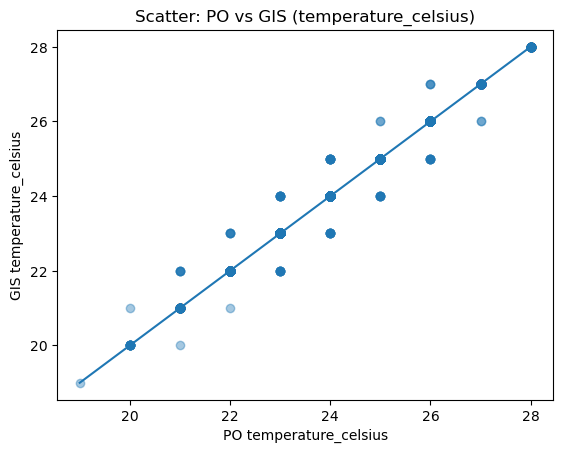

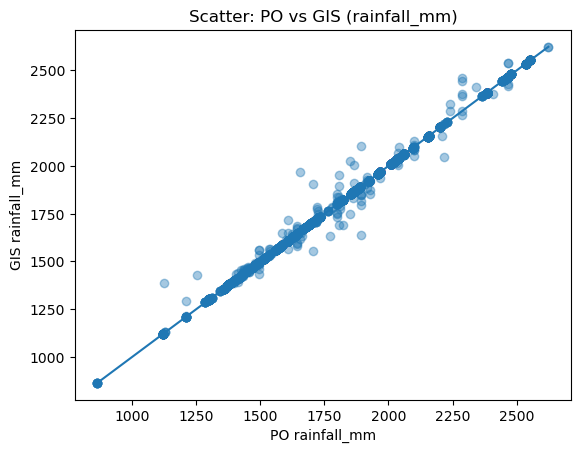

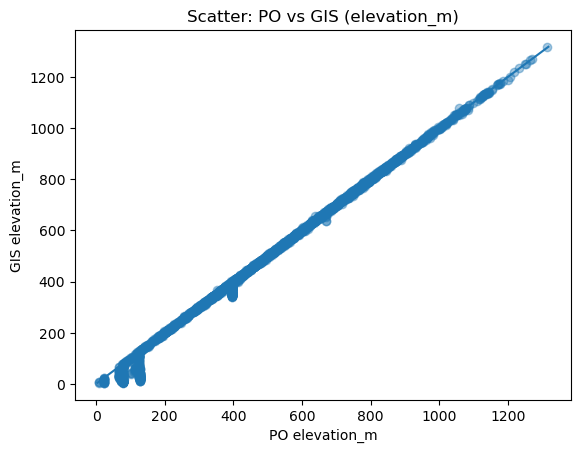

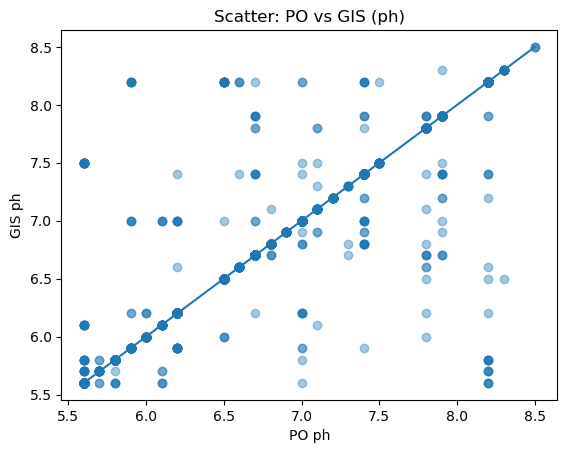

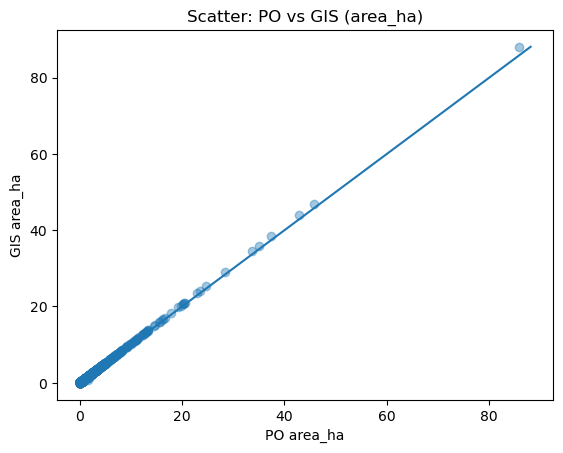

In [80]:
# Implementation the scatterplot function
def plot_scatter_po_vs_gis(col):
    x_po = pd.to_numeric(po_matched[col], errors="coerce")
    y_gis = pd.to_numeric(gis_farms[col], errors="coerce")

    mask = gis_farms["matched_by_coord"] & x_po.notna() & y_gis.notna()
    x = x_po[mask]
    y = y_gis[mask]

    plt.figure()
    plt.scatter(x, y, alpha=0.4)

    # identity line y=x
    lo = float(min(x.min(), y.min()))
    hi = float(max(x.max(), y.max()))
    plt.plot([lo, hi], [lo, hi])

    plt.xlabel(f"PO {col}")
    plt.ylabel(f"GIS {col}")
    plt.title(f"Scatter: PO vs GIS ({col})")
    plt.show()


for col in COMPARE_COLS_NUM:
    plot_scatter_po_vs_gis(col)

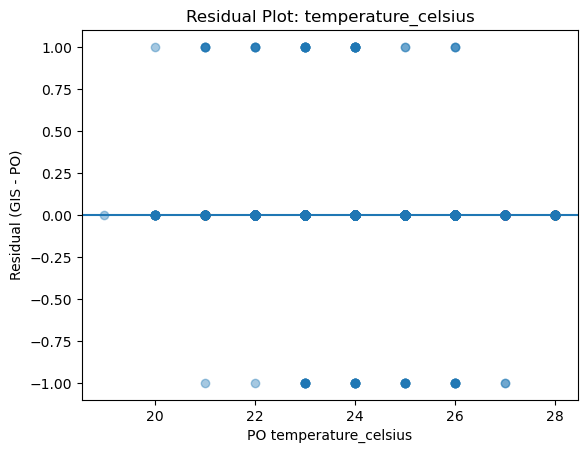

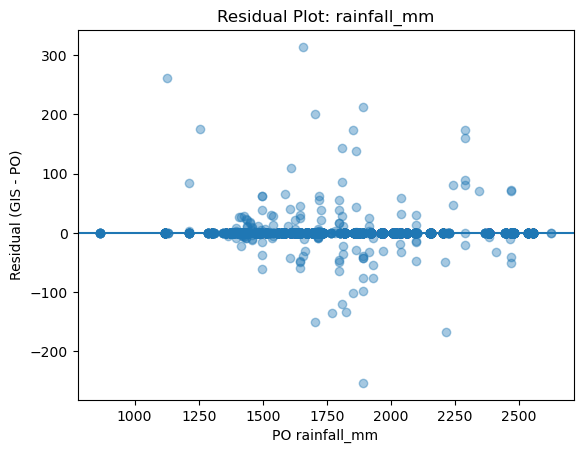

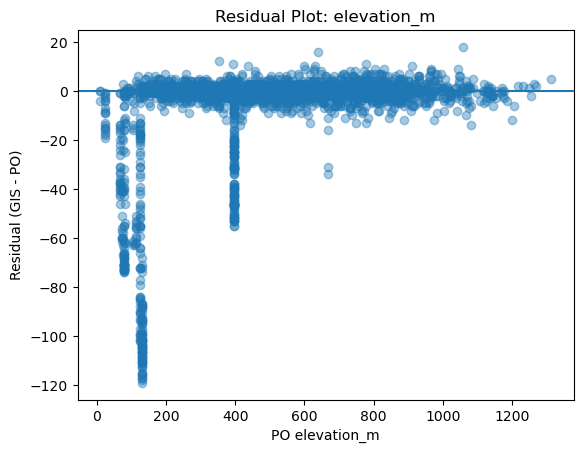

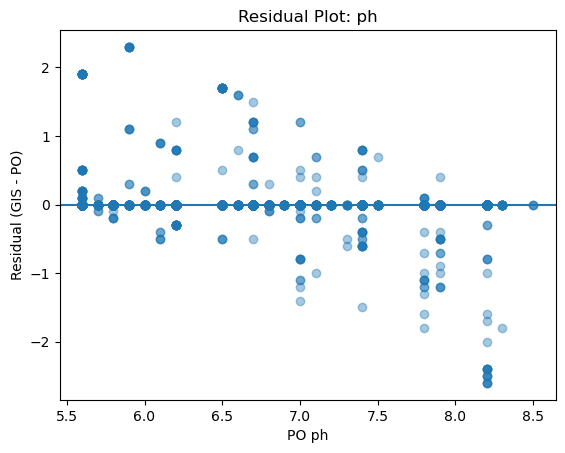

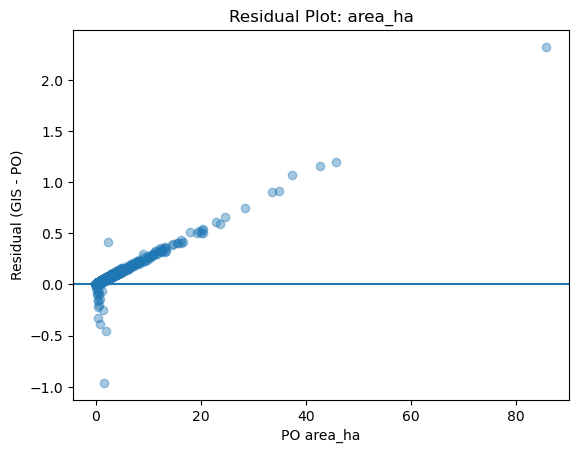

In [81]:
# Implementation the residual plot
def plot_residual(col):
    po = pd.to_numeric(po_matched[col], errors="coerce")
    gis = pd.to_numeric(gis_farms[col], errors="coerce")

    mask = gis_farms["matched_by_coord"] & po.notna() & gis.notna()

    po_x = po[mask]
    residual = (gis - po)[mask]

    plt.figure()
    plt.scatter(po_x, residual, alpha=0.4)
    plt.axhline(0)
    plt.xlabel(f"PO {col}")
    plt.ylabel("Residual (GIS - PO)")
    plt.title(f"Residual Plot: {col}")
    plt.show()


for col in COMPARE_COLS_NUM:
    plot_residual(col)

#### Interpretation of Validation Results 

Table 3 reports Pearson and Spearman correlations between gis farm dataset and PO farm dataset and and MAE (average absolute error in original units) regardinng environmental factors that were successfully matched by coordinates. Overall, the correlations are consistently high, indicating strong agreement and internal consistency between the two datasets after spatial alignment.

- **Temperature** (Pearson = 0.9943, Spearman = 0.9936; n = 3184, MAE = 0.0242°C):
Temperature shows near-perfect agreement with low error. The scatter plot points lie very close to the identity line, while the residual plot is concentrated around 0, with only small ±1°C deviations. Additionally, temperature shows very strong agreement. Both correlation metrics are close to 1, suggesting this value in gis farm dataset and PO farm dataset are highly consistent and maintain both similar magnitude and ranking across farms.

- **Rainfall** (Pearson = 0.9990, Spearman = 0.9990; n = 3193, MAE = 2.1149 mm):
Rainfall exhibits almost identical values between datasets with low error. The scatter plot forms a tight diagonal band along the 1:1 line, confirming strong agreement across the full range. The residual plot is centered near zero with a small number of outliers, suggesting occasional local differences. Addionally, Rainfall has near-perfect consistency. This indicates gis farm dataset's rainfall extraction is almost identical to PO’s rainfall values, and the spatial matching is behaving correctly for this variable.

- **Elevation** (Pearson = 0.9976, Spearman = 0.9984; n = 3193, MAE = 7.9305 m):
Elevation remains highly consistent (very strong correlations), and the scatter plot aligns closely with the identity line. However, the residual plot shows more spread than other variables and includes some negative residual clusters, consistent with its larger deviation. Minor differences may still exist due to DEM source, resolution or extraction method, but the overall pattern remains nearly identical.

- **pH** (Pearson = 0.9301, Spearman = 0.9275; n = 3146, MAE = 0.0743):
pH has the lowest correlation among the numeric fields and visibly larger dispersion in both scatter and residual plots compared to other fields, although the absolute error is still small. Specifically, the residual plot suggests non-uniform error across the pH range (some areas show larger positive/negative deviations), which could be impacted by differences in soil datasets, spatial resolution, or interpolation methods. Despite being the least aligned variable, the MAE remains relatively small in absolute terms, this suggests pH is the variable with the most variation between gis farm dataset and PO farm dataset. It is a key field to investigate further if the project requires strict agreement. 

- **Area** (Pearson = 1.0000, Spearman = 0.9992; n = 3193, MAE = 0.0400 ha):
Area is essentially perfectly aligned, with scatter points following the identity line almost exactly with minimal error. The residual plot is tightly centered near zero for most farms, with a small number of larger farms showing higher residuals. This pattern often occurs when a few large polygons dominate the scale, or when minor geometry processing differences are magnified for large areas.

 Pearson and Spearman values are consistently close for each variable, which indicates that the relationship between gis and PO is both strongly linear (Pearson) and order-consistent (Spearman). This supports the conclusion that gis extraction preserves both the magnitude and the relative ranking of PO values for most numeric factors.

Table 4 provides a high-level “overall correlation” by stacking all numeric gis farm environmental values and PO farm envrionmental values into paired values, which creates a combined dataset (15,909 paired points in total) and computing a single Pearson and Spearman correlation. The results are extremely high (Pearson = 0.9999, Spearman = 0.9975), which confirms that, in aggregate, gis farm dataset and PO farm dataset values are strongly consistent after coordinate matching.

## III. Limitation

#### Impact of Coordinate Reference System (CRS) Misalignment on Extraction Accuracy

A key driver of the remaining mismatch is coordinate reference system (CRS) inconsistency across the PO boundary files used at different stages. In practice, mixing CRS such as EPSG:4326, EPSG:3857, and EPSG:32751 can introduce subtle but meaningful geometry shifts when boundaries are read, reprojected, or interpreted without an explicit, consistent CRS. Even small positional shifts can change which raster pixels are sampled, especially for higher-gradient surfaces like elevation or heterogeneous layers like soil attributes which leads to systematic differences in extracted values (bias) and increased residual spread. To reduce this source of error, the validation workflow should enforce a single standard CRS for all geometries before extraction (i.e., convert all farm boundaries and envrionmental data to a consistent CRS and ensure sampling is performed using a compatible projection and scale).

However, CRS standardisation itself has trade-offs, particularly when transforming from a high  CRS (EPSG:32751) to low CRS (EPSG:3857). This transformation can introduce projection distortion (e.g., changes in distance/area representation) and small numerical differences in geometry coordinates, which may slightly affect derived attributes such as area and the exact pixel footprint used during raster sampling.

## IV. Conclusion

The results indicate strong consistency between the two datasets. 99.94% (3,193/3,195) of gis farms were successfully matched to a PO farm by coordinates, confirming that spatial alignment is reliable. Using the score-based validation, 91.74% (2,931/3,195) of farms met the overall agreement threshold, showing that most farms match across the majority of environmental factors. Field-level match rates were high across all variables, which is proved throught the table 2. Specifically, they shows the strongest agreement observed in temperature and rainfall, while elevation and soil texture showed slightly lower agreement, likely due to differences in dataset resolution, extraction method, CRS or classification. Moreover, correlation analysis further supported these findings were consistently high, and the overall stacked correlation was near-perfect, indicating that gis farm environmental values closely follow PO trends after coordinate matching. Among numeric variables, pH exhibited the lowest correlation, suggesting it is the primary source of remaining discrepancies and may require additional investigation if strict equivalence is required. Therefore, the validation provides strong evidence that gis farm dataset is broadly aligned with the PO dataset and is suitable for downstream use and gis logic of extracting enviornment have high accuracy score. 